# Faster R-CNN Implementations by Pytorch

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(DEVICE, torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device("cpu")
    print(DEVICE)

cuda GeForce RTX 3090


# Data Preprocessing

1) Visualize image and bounding boxes

(2160, 3840, 3)


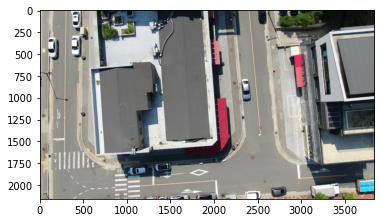

In [3]:
img0 = cv2.imread("/home/lee/research/20210627fasterrcnn/drone_city_data/00000067.jpg")
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show()

2
(2160, 3840, 3)
2310 784 2416 1027


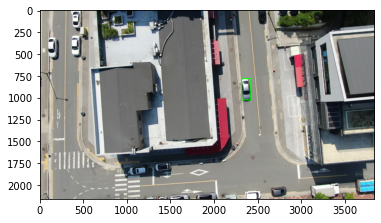

In [4]:
import json
import os

with open("/home/lee/research/20210627fasterrcnn/drone_city_data/00000067.json", "r") as json_file:
    data = json.load(json_file)
    shapes = data["shapes"]
    data_bbox = np.asarray(shapes[0]["points"])
    print(len(data_bbox))

img0_clone = np.copy(img0)
print(img0_clone.shape)
print(int(data_bbox[0][0]), int(data_bbox[0][1]), int(data_bbox[1][0]), int(data_bbox[1][1]))
cv2.rectangle(img0_clone, (int(data_bbox[0][0]), int(data_bbox[0][1])), (int(data_bbox[1][0]), int(data_bbox[1][1])), color=(0,255,0), thickness=10)
plt.imshow(img0_clone)
plt.show()


In [5]:
import json
import os

with open("/home/lee/research/20210627fasterrcnn/drone_city_data/00000067.json", "r") as json_file:
    data = json.load(json_file)
    shapes = data["shapes"]
    print(shapes)
    data_label = np.asarray(shapes[0]["label"])
    data_bbox = np.asarray(shapes[0]["points"])
    print(len(data_bbox), data_label)
    

[{'label': 'car_vehicle, 승용차', 'points': [[2310.6216216216217, 784.7297297297298], [2416.027027027027, 1027.972972972973]], 'shape_type': 'bbox'}, {'label': 'car_vehicle, 승용차', 'points': [[361.97297297297297, 295.5405405405405], [467.3783783783784, 522.5675675675676]], 'shape_type': 'bbox'}, {'label': 'car_vehicle, 승용차', 'points': [[91.70270270270271, 311.7567567567568], [216.02702702702703, 560.4054054054054]], 'shape_type': 'bbox'}, {'label': 'car_vehicle, 승용차', 'points': [[372.7837837837838, 0.9459459459459367], [486.2972972972973, 206.35135135135135]], 'shape_type': 'bbox'}, {'label': 'car_vehicle, 승용차', 'points': [[1324.1351351351352, 1741.4864864864865], [1502.5135135135135, 1841.4864864864867]], 'shape_type': 'bbox'}, {'label': 'car_vehicle, 승용차', 'points': [[2648.4594594594596, 2017.162162162162], [2826.837837837838, 2133.3783783783783]], 'shape_type': 'bbox'}]
2 car_vehicle, 승용차


car_vehicle, 승용차
car_vehicle, 승용차
car_vehicle, 승용차
car_vehicle, 승용차
car_vehicle, 승용차
car_vehicle, 승용차
[14 14 14 14 14 14]


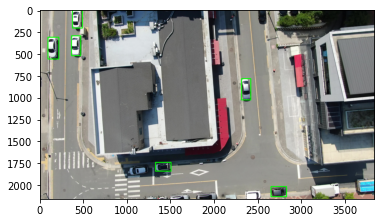

In [6]:
import json
import os
CLASSES = ('tree, 나무', 'person, 사람', 'animal, 동물', 'house, 주택', 'apartment, building, 아파트, 빌딩', 
           'school', 'office, 사무실', 'traffic sign', 'traffic light, 신호등', 
           'streetlamp, telephone pole', 'banner','milestone, 정상표식', 'bridge, 다리', 
           'tower, ', 'car_vehicle, 승용차', 'bus_vehicle, 버스', 'truck_vehicle, 트럭', 
           'motorcycle, bike_vehicle, 오토바이, 자전거')
# print(type(CLASSES.index("car_vehicle, 승용차")))


with open("/home/lee/research/20210627fasterrcnn/drone_city_data/00000067.json", "r") as json_file:
    data = json.load(json_file)
    shapes = data["shapes"]
    bbox_list = []
    label_list = []
    labels = []
    for i in range(len(shapes)):
        bbox_list.append(shapes[i]["points"])
        label_list.append(shapes[i]["label"])
#     print("list points\n", bbox)
    data_bbox = np.asarray(bbox_list)
#     label_array = np.asarray(label_list)
#     print(len(label_list))
#     print(label_list[0])
    for j in range(len(label_list)):
        print(label_list[j])
        label_index = CLASSES.index(label_list[j])
        labels.append(label_index)
labels = np.asarray(labels)
print(labels)
img0_clone = np.copy(img0)
# print(img0_clone.shape)
for i in range(len(data_bbox)):
#     print(int(data_bbox[i][0][0]), int(data_bbox[i][0][1]), int(data_bbox[i][1][0]), int(data_bbox[i][1][1]))
    cv2.rectangle(img0_clone, (int(data_bbox[i][0][0]), int(data_bbox[i][0][1])), (int(data_bbox[i][1][0]), int(data_bbox[i][1][1])), color=(0,255,0), thickness=10)
plt.imshow(img0_clone)
plt.show()

    

2)Resize image and bounding boxes

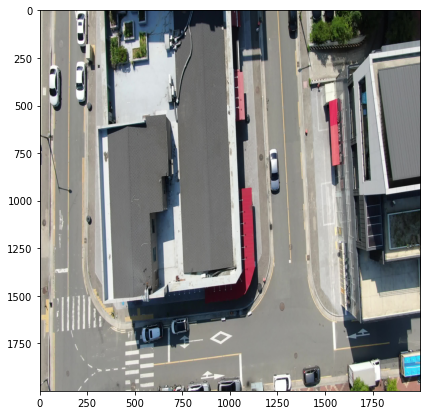

In [7]:
img = cv2.resize(img0, dsize=(2000, 2000), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(7, 7))
plt.imshow(img)
# plt.grid(True, color="black")
plt.show()

0.5208333333333334 0.9259259259259259


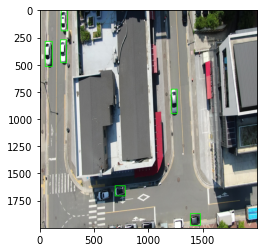

In [8]:
# change the bounding box coordinates
# original image size : (3840, 2160)

Wratio = 2000/img0.shape[1]
Hratio = 2000/img0.shape[0]

print(Wratio, Hratio)

ratioList = [Wratio, Hratio, Wratio, Hratio]
bbox = []

for box in data_bbox:
    box = [box[0][0], box[0][1], box[1][0], box[1][1]]
#     print(box)
    box = [int(a*b) for a, b in zip(box, ratioList)]
    bbox.append(box)
    
bbox = np.array(bbox)
# print(bbox)

img_clone = np.copy(img)
for i in range(len(bbox)):
#     print(int(data_bbox[i][0][0]), int(data_bbox[i][0][1]), int(data_bbox[i][1][0]), int(data_bbox[i][1][1]))
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0, 255, 0), thickness=5)
plt.imshow(img_clone)
plt.show()

# Define Feature extractor

1) Load pretrained VGG16

In [9]:
model = torchvision.models.vgg16(pretrained=True).to(DEVICE)
features = list(model.features)
print(len(features))
print(features)

31
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

2) Only collect required layers

In [10]:
# only collect layers with output feature map size (W, H) < 50

dummy_img = torch.zeros((1, 3, 2000, 2000)).float() # test image array
print(dummy_img.shape)

req_features = []
output = dummy_img.clone().to(DEVICE)

for feature in features:
    output = feature(output)
#     print(output.size()) => torch.Size([batch_size, channel, width, height])
    if output.size()[2] < 2000//16: # 800/16=50
        break
    req_features.append(feature)
    out_channels = output.size()[1]
    
print(len(req_features))
# print(req_features)
print(out_channels)

torch.Size([1, 3, 2000, 2000])
30
512


In [11]:
# convert this list into a Seqeuntial module
faster_rcnn_feature_extractor = nn.Sequential(*req_features)

In [12]:
# test the results of the input image pass through the feature extractor

transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(DEVICE)
imgTensor = imgTensor.unsqueeze(0)
output_map = faster_rcnn_feature_extractor(imgTensor)

print(output_map.size())

torch.Size([1, 512, 125, 125])


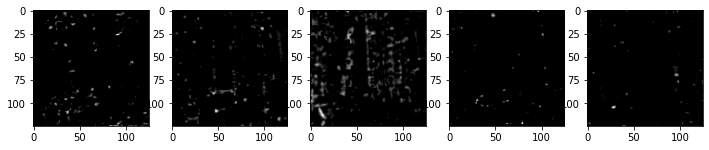

In [13]:
# visualize the first 5 channels of the 50*50*512 feature maps

imgArray = output_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1
    
plt.show()

# Generate Anchors Boxes

1) Generate Anchors

In [14]:
# sub-sampling rate = 1/16
# image size : 2000x2000
# sub-sampled feature map size : 2000 x 1/16 = 125
# 50 x 50 = 2500 anchors and each anchor generate 9 anchor boxes
# total anchor boxes = 125 x 125 x 9 = 140625
# x,y intervals to generate anchor box center

feature_size = 2000 // 16
ctr_x = np.arange(16, (feature_size + 1) * 16, 16)
ctr_y = np.arange(16, (feature_size + 1) * 16, 16)
print(len(ctr_x))
print(ctr_x)

125
[  16   32   48   64   80   96  112  128  144  160  176  192  208  224
  240  256  272  288  304  320  336  352  368  384  400  416  432  448
  464  480  496  512  528  544  560  576  592  608  624  640  656  672
  688  704  720  736  752  768  784  800  816  832  848  864  880  896
  912  928  944  960  976  992 1008 1024 1040 1056 1072 1088 1104 1120
 1136 1152 1168 1184 1200 1216 1232 1248 1264 1280 1296 1312 1328 1344
 1360 1376 1392 1408 1424 1440 1456 1472 1488 1504 1520 1536 1552 1568
 1584 1600 1616 1632 1648 1664 1680 1696 1712 1728 1744 1760 1776 1792
 1808 1824 1840 1856 1872 1888 1904 1920 1936 1952 1968 1984 2000]


In [78]:
# coordinates of the 255 center points to generate anchor boxes

index = 0
ctr = np.zeros((140625, 2))

for i in range(len(ctr_x)):
    for j in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[i] - 8
        ctr[index, 0] = ctr_y[j] - 8
        index += 1

# ctr => [[center x, center y], ...]
print(ctr.shape)
print(ctr[:50, :])

(140625, 2)
[[1798.91778374 1849.195158  ]
 [ 372.02277879 1849.195158  ]
 [ 133.86414931 1849.195158  ]
 [1815.28394079 1849.195158  ]
 [ 321.64145751 1849.195158  ]
 [ 830.07914541 1849.195158  ]
 [ 632.58080002 1849.195158  ]
 [ 590.13299549 1849.195158  ]
 [1051.07085094 1849.195158  ]
 [1460.46482134 1849.195158  ]
 [1424.67218129 1849.195158  ]
 [ 155.6989006  1849.195158  ]
 [1894.88685394 1849.195158  ]
 [ 924.89715205 1849.195158  ]
 [1395.11635787 1849.195158  ]
 [1523.12836905 1849.195158  ]
 [1827.50958204 1849.195158  ]
 [1110.44305374 1849.195158  ]
 [1899.23310471 1849.195158  ]
 [1828.1689958  1849.195158  ]
 [ 490.50411987 1849.195158  ]
 [1681.39444795 1849.195158  ]
 [1417.56301001 1849.195158  ]
 [ 741.15110716 1849.195158  ]
 [1686.37530831 1849.195158  ]
 [ 784.92711196 1849.195158  ]
 [1062.41639266 1849.195158  ]
 [1691.24354553 1849.195158  ]
 [  29.34739303 1849.195158  ]
 [ 559.98751298 1849.195158  ]
 [ 381.00904654 1849.195158  ]
 [ 743.09329224 1849.195158

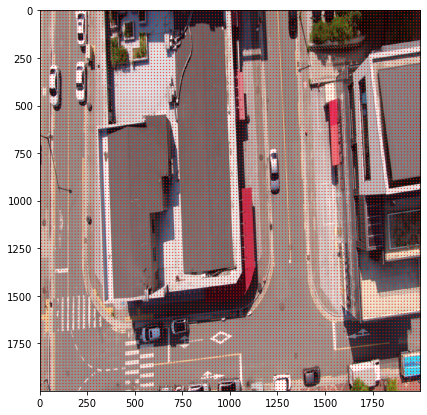

In [16]:
# display the 2500 anchors within image

img_clone2 = np.copy(img)
ctr_int = ctr.astype("int32")

plt.figure(figsize=(7, 7))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone2, (ctr_int[i][0], ctr_int[i][1]),
              radius=1, color=(255, 0, 0), thickness=3)
plt.imshow(img_clone2)
plt.show()

2) Generate Anchor boxes

In [88]:
# for each of the 15,625 anchors, generate 9 anchor boxes
# 15,625 x 9 = 140,625 anchor boxes

ratios = [0.5, 1, 2]
scales = [32, 64, 128]
sub_sample = 16
print(feature_size)
anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4))
index = 0

for c in ctr:                        # per anchors
    ctr_y, ctr_x = c
    for i in range(len(ratios)):     # per ratios
        for j in range(len(scales)): # per scales
            
            # anchor box height, width
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
#             print("index", index)
            # anchor box [x1, y1, x2, y2]
            if index < feature_size * feature_size * 9:
                anchor_boxes[index, 1] = ctr_y - h / 2.
                anchor_boxes[index, 0] = ctr_x - w / 2.
                anchor_boxes[index, 3] = ctr_y + h / 2.
                anchor_boxes[index, 2] = ctr_x + w / 2.
                index += 1
            
print(anchor_boxes.shape)
print(anchor_boxes[:10, :])

125
(140625, 4)
[[1487.15648604 1617.89844775 2211.23382997 1979.93711972]
 [1125.11781407 1436.87911177 2573.27250194 2160.9564557 ]
 [ 401.04047013 1074.8404398  3297.34984587 2522.99512767]
 [1593.195158   1542.91778374 2105.195158   2054.91778374]
 [1337.195158   1286.91778374 2361.195158   2310.91778374]
 [ 825.195158    774.91778374 2873.195158   2822.91778374]
 [1668.17582202 1436.87911177 2030.21449399 2160.9564557 ]
 [1487.15648604 1074.8404398  2211.23382997 2522.99512767]
 [1125.11781407  350.76309587 2573.27250194 3247.07247161]
 [1487.15648604  191.0034428  2211.23382997  553.04211477]]


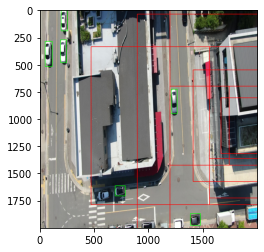

In [89]:
# display the anchor boxes of one anchor and the ground truth boxes

img_clone = np.copy(img)

# draw random anchor boxes
for i in range(100000, 100009):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)

# draw ground truth boxes
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), 
                             (bbox[i][2], bbox[i][3]),
                 color=(0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

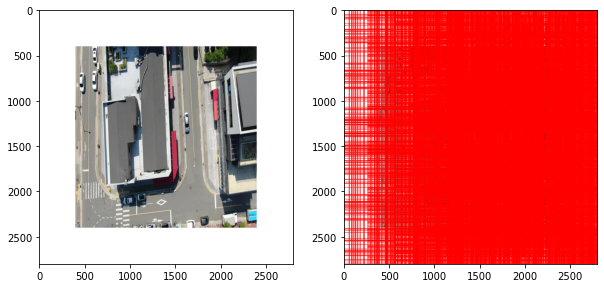

In [90]:
# draw all anchor boxes

# add paddings(can't draw anchor boxes out of image boundary)
img_clone3 = np.copy(img)
img_clone4 = cv2.copyMakeBorder(img_clone3,400,400,400,400,cv2.BORDER_CONSTANT, value=(255, 255, 255))
img_clone5 = np.copy(img_clone4)

for i in range(len(anchor_boxes)):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone5, (x1+400, y1+400), (x2+400, y2+400), color=(255, 0, 0),
                 thickness=3)

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

# Target Anchors

1) Only choose anchor boxes inside the image

In [91]:
# ignore the cross-boundary anchor boxes
# valid anchor boxes with (x1, y1) > 0 and (x2, y2) <= 2000

index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 2000) &
        (anchor_boxes[:, 3] <= 2000))[0]

print(index_inside.shape)
print(index_inside)
# only 100665 anchor boxes are inside the boundary out of 140625
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(34325,)
[  1152   1161   1162 ... 140532 140538 140541]
(34325, 4)


2) Calculate IoUs

In [94]:
# calculate Iou of the valid anchor boxes
# since we have 8940 anchor boxes and 4 ground truth objects,
# we should get an array with (8940, 4) as the output
# [IoU with gt box1, IoU with gt box2, IoU with gt box3,IoU with gt box4]
# if number of bboxes are 6, ious = len(valid_anchor_boxes, num_box)
num_box = bbox.shape[0]
ious = np.empty((len(valid_anchor_boxes),num_box), dtype=np.float32)
ious.fill(0)

# anchor boxes
for i, anchor_box in enumerate(valid_anchor_boxes):
    xa1, ya1, xa2, ya2 = anchor_box
    anchor_area = (xa2 - xa1) * (ya2 - ya1)
    
    # ground truth boxes
    
    for j, gt_box in enumerate(bbox):
#         print("j", j, gt_box)
        xb1, yb1, xb2, yb2 = gt_box
        box_area = (xb2 - xb1) * (yb2 - yb1)
#         print("box_area", box_area)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])

        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0

        ious[i, j] = iou

print(ious.shape)
print(ious[30000:30009:])

(34325, 6)
[[0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.03382153]
 [0.02515554 0.         0.         0.         0.         0.        ]
 [0.04119018 0.         0.         0.         0.         0.        ]
 [0.01180172 0.         0.         0.         0.         0.        ]
 [0.04720688 0.         0.         0.         0.         0.        ]
 [0.02878236 0.         0.         0.         0.         0.        ]
 [0.04493156 0.         0.         0.         0.         0.        ]
 [0.01180172 0.         0.         0.         0.         0.        ]]


3) Sample positive/negative anchor boxes

In [95]:
# what anchor box has max ou with the ground truth box

gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[    8 11824     0 11824   851     0]
[0.04720688 0.01101494 0.         0.01017946 0.03299332 0.03831482]
[    0     0     1 ... 34322 34323 34324]


In [96]:
# what ground truth bbox is associated with each anchor box

argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(34325,)
[5 0 0 ... 0 0 0]
[0.03831482 0.         0.00041808 ... 0.         0.         0.        ]


In [99]:
# set the labels of 8940 valid anchor boxes to -1(ignore)

label = np.empty((len(index_inside),), dtype=np.int32)
label.fill(-1)
print(label.shape)
# print(label)

(34325,)


In [100]:
# use IoU to assign 1 (objects) to two kind of anchors
# a) the anchors with the highest IoU overlap with a ground truth box
# b) an anchor that has an IoU overlap higher than 0.7 with ground truth box

# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3

pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0
print(label)

[0 0 0 ... 0 0 0]


In [101]:
# Every time mini-batch training take only 256 valid anchor boxes to train RPN
# of which 128 positive examples, 128 negative-examples
# disable leftover positive/negative anchors 
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]

if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index,
                                    size = (len(pos_index) - n_pos),
                                    replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, 
                                    size = (len(neg_index) - n_neg), 
                                    replace = False)
    label[disable_index] = -1

In [102]:
# convert the format of valid anchor boxes [x1, y1, x2, y2]

# For each valid anchor box, find the groundtruth object which has max_iou 
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width = valid_anchor_boxes[:, 2] = valid_anchor_boxes[:, 0]
ctr_y = valid_anchor_boxes[:, 1] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 0] + 0.5 * width

base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_ctr_y = max_iou_bbox[:, 1] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 0] + 0.5 * base_width

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(anchor_locs.shape)

(34325, 4)
(34325, 4)


In [103]:
# First set the label=-1 and locations=0 of the 22500 anchor boxes, 
# and then fill in the locations and labels of the 8940 valid anchor boxes
# NOTICE: For each training epoch, we randomly select 128 positive + 128 negative 
# from 8940 valid anchor boxes, and the others are marked with -1

anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)
print(anchor_labels[:10])

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)
print(anchor_locations[:10, :])

(140625,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(140625, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


# RPN(Region Proposal Network)

1) Define RPN

In [104]:
# Send the features of the input image to the Region Proposal Network (RPN), 
# predict 22500 region proposals (ROIs)

in_channels = 512
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(DEVICE)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

# bounding box regressor
reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0).to(DEVICE)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# classifier(object or not)
cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0).to(DEVICE)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

2) Classification and Bounding box regression

In [105]:
x = conv1(output_map.to(DEVICE)) # output_map = faster_rcnn_feature_extractor(imgTensor)
pred_anchor_locs = reg_layer(x) # bounding box regresor output
pred_cls_scores = cls_layer(x)  # classifier output 

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 125, 125]) torch.Size([1, 18, 125, 125])


In [106]:
# Convert RPN to predict the position and classification format of the anchor box
# Position: [1, 36(9*4), 50, 50] => [1, 22500(50*50*9), 4] (dy, dx, dh, dw) 
# Classification: [1, 18(9*2), 50, 50] => [1, 22500, 2] (1, 0)

pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 125, 125, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)


torch.Size([1, 140625, 4])
torch.Size([1, 125, 125, 18])
torch.Size([1, 140625])
torch.Size([1, 140625, 2])


In [107]:
# According to the 22500 ROIs predicted by RPN and 22500 anchor boxes, 
# calculate the RPN loss¶
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 140625, 4])
torch.Size([1, 140625, 2])
(140625, 4)
(140625,)


In [108]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape,
      gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([140625, 4]) torch.Size([140625, 2]) torch.Size([140625, 4]) torch.Size([140625])


3) Multi-task loss

In [112]:
# For classification we use cross-entropy loss
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(DEVICE), ignore_index = -1)
print(rpn_cls_loss)

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


In [113]:
# only positive samples
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes whick have positive labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(rpn_loc_loss.sum())

torch.Size([140625, 4])
torch.Size([0, 4]) torch.Size([0, 4])
tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)


In [114]:
# Combining both the rpn_cls_loss and rpn_reg_loss

rpn_lambda = 10
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(nan, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


# Proposal layer

1) Transform anchor boxes

In [115]:
# Send the 22500 ROIs predicted by RPN to Fast RCNN to predict bbox + classifications
# First use NMS (Non-maximum supression) to reduce 22500 ROI to 2000

nms_thresh = 0.7  # non-maximum supression (NMS) 
n_train_pre_nms = 12000 # no. of train pre-NMS
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 6000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [116]:
# the labelled 22500 anchor boxes
# format converted from [x1, y1, x2, y2] to [ctrx, ctry, w, h]

anc_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_ctr_y = anchor_boxes[:, 1] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 0] + 0.5 * anc_width
print(anc_ctr_x.shape)

(140625,)


In [117]:
# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dx, dy, dw, dh)

pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

dy = pred_anchor_locs_numpy[:, 1::4]
dx = pred_anchor_locs_numpy[:, 0::4]
dh = pred_anchor_locs_numpy[:, 3::4]
dw = pred_anchor_locs_numpy[:, 2::4]
print(dy.shape)

(140625, 1)


In [118]:
# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar

ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(140625, 1)


In [119]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_x - 0.5 * w
roi[:, 1::4] = ctr_y - 0.5 * h
roi[:, 2::4] = ctr_x + 0.5 * w
roi[:, 3::4] = ctr_y + 0.5 * h

print(roi.shape)

(140625, 4)


2) Clip the anchor boxes to the image

In [120]:
# clip the predcited boxes to the image

img_size = (2000, 2000)
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0]) # [:, 0, 2]
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1]) # [:, 1, 3]

print(roi.shape, np.max(roi), np.min(roi))

(140625, 4) 2000.0 0.0


In [121]:
# remove predicted boxes with either height or width < threshold

hs = roi[:, 3] - roi[:, 1]
ws = roi[:, 2] - roi[:, 0]

keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

(140625,) (140625, 4) (140625,)


3) Select top-12000 anchor boxes by objectness score

In [122]:
# sort all (proposal, score) pairs by score from highest to lowest

order = score.ravel().argsort()[::-1]
print(order.shape)

(140625,)


In [123]:
# take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape)

(12000,) (12000, 4)


4) Non maximum suppression(select 2000 bounding boxes)

In [124]:
# take all the roi boxes
x1 = roi[:, 0]
y1 = roi[:, 1]
x2 = roi[:, 2]
y2 = roi[:, 3]

# find the areas of all the boxes

areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [125]:
# take the indexes of order the probability score in descending order
# non maximum suppression

order = order.argsort()[::-1]
keep = []

while (order.size > 0):
    i = order[0] # take the 1st elt in roder and append to keep
    keep.append(i)

    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])

    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)

    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]

keep = keep[:n_train_post_nms] # while training/testing, use accordingly
roi = roi[keep]
print(len(keep), roi.shape)

744 (744, 4)


# Proposal Target layer

1) Calculate IoUs

In [126]:
n_sample = 128 # number of samples from roi
pos_ratio = 0.25 # number of positive examples out of the n_samples
pos_iou_thresh = 0.5 # min iou of region proposal with any ground truth object to consider it as positive label
neg_iou_thresh_hi = 0.5 # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [127]:
# fine the iou of each ground truth object with the region proposals

ious = np.empty((len(roi), bbox.shape[0]), dtype = np.float32)
ious.fill(0)

for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)

    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2 - yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])

        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0
        ious[num1, num2] = iou

print(ious.shape)

(744, 6)


In [128]:
# find out whick ground truth has high IoU for each region proposal
# also find the maximum IoU

gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)

print(gt_assignment)
print(max_iou)

# assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 5 0 0 5 0 0 0 0 0 0 0
 0 0 5 0 5 0 0 0 0 0 0 0 0 0 5 5 0 5 0 5 0 0 0 0 0 0 0 5 5 0 0 0 0 0 2 0 0
 0 0 1 5 5 0 0 0 0 0 0 0 5 0 5 5 0 0 0 0 5 0 5 0 0 0 0 0 0 5 5 5 0 0 0 5 0
 0 0 0 0 0 0 5 0 0 0 0 5 0 5 5 0 0 0 0 0 0 0 0 4 5 5 0 0 0 0 0 5 0 0 0 0 0
 5 0 0 0 0 0 0 5 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 5 0 0 0 0 0 0 0
 4 0 0 2 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0
 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0
 0 0 4 5 0 0 0 0 0 5 4 0 4 0 4 0 0 0 4 0 4 0 0 0 0 4 4 0 4 5 4 0 0 2 4 4 0
 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 5 0 0 0 0 0 0
 0 0 4 4 0 0 0 4 0 0 0 0 0 4 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 4 0 0 4 4 0 0 0 0 0 0 0 0 0 0 0 4 0 2 0 0 0 4 0 0 0 4 0 4 0 4 0 0
 0 4 4 4 0 0 0 0 0 0 0 0 0 0 0 5 0 0 5 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 5 0
 0 0 0 5 0 0 0 0 5 0 0 0 5 5 0 0 4 0 4 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 4 0 0
 4 4 4 0 0 4 5 0 0 0 2 4 

2) Select foreground(positive) samples

In [129]:
# select the foreground rois as pre the pos_iou_thresh
# and n_sample x pos_ratio (128 x 0.25 = 32) foreground samples

pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))

if pos_index.size > 0:
    pos_index = np.random.choice(
    pos_index, size=pos_roi_per_this_image, replace=False)

print(pos_roi_per_this_image)
print(pos_index)

0
[]


3) Select background(negative) samples

In [130]:
# similarly we do for negative(background) region proposals

neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                     (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))

if neg_index.size > 0:
    neg_index = np.random.choice(
    neg_index, size = neg_roi_per_this_image, replace=False)
    
print(neg_roi_per_this_image)
print(neg_index)

128
[731 222 650 270  43 567 137 622  37 459 550 556   6 253  98 530 695 443
 130 440 447 455  85 335 351 657 566 740 408 414 294 437 617 119 149 475
 536 520 272 722 709 743 358 296 648 649 627 702 115 509 526 449 173 183
 181 302 603 486 340 452 388 215 485 562 291 228  97 519 545 638 141 559
 300 632 463 197 251 494 469 307  70 355 268 391 203  86  55 692 668 633
 231 118  22 584 157 290 430 143  54 630  68 103 101 258 688 170 512 493
 158 523 190 233 592 499 263 474  89 502 514 106 224 698 120 578 465 438
 195 200]


4) Visualization

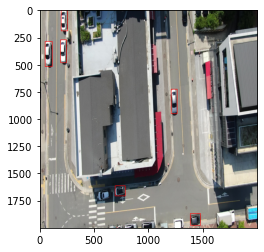

In [131]:
# display RoI samples with positive

img_clone = np.copy(img)

for i in range(pos_roi_per_this_image):
    x1, y1, x2, y2 = roi[pos_index[i]].astype(int)
#     print(x1, y1, x2, y2)
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255,255,255),
                thickness=3)

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (255, 0, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

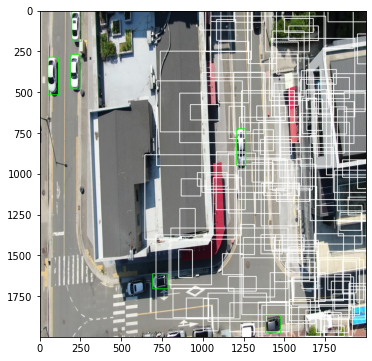

In [57]:
# display RoI samples with negative

img_clone = np.copy(img)

plt.figure(figsize=(9, 6))

for i in range(neg_roi_per_this_image):
    x1, y1, x2, y2 = roi[neg_index[i]].astype(int)
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 255, 255),
                thickness=3)

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

5) Gather positive/negative samples

In [132]:
# now we gather positive samples index and negative samples index
# their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0 # negative labels => 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

(128, 4)


In [133]:
# pick the ground truth objects for these sample_roi and
# later parameterized as we have done while assigning locations to 
# anchor boxes

bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

(128, 4)


In [134]:
width = sample_roi[:, 2] - sample_roi[:, 0]
height = sample_roi[:, 3] - sample_roi[:, 1]
ctr_x = sample_roi[:, 0] + 0.5 * width
ctr_y = sample_roi[:, 1] + 0.5 * height

base_width = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_height = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_x = bbox_for_sampled_roi[:, 0] + 0.5 * base_width
base_ctr_y = bbox_for_sampled_roi[:, 1] + 0.5 * base_height

In [135]:
# transform anchor boxes

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dx = (base_ctr_x - ctr_x) / width
dy = (base_ctr_y - ctr_y) / height
dw = np.log(base_width / width)
dh = np.log(base_height / height)

gt_roi_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(gt_roi_locs.shape)

(128, 4)


# RoI pooling

1) Concatenate labels with bbox coordinates

In [136]:
# Take out the features of 128 ROI samples and 
# use max pooling to adjust to the same size, H=7, W=7 (ROI Pooling)

rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

torch.Size([128, 4]) torch.Size([128])


In [137]:
indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 5])


2) RoI pooling

In [138]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [139]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # sub-sampling ratio
rois = rois.long()
num_rois = rois.size(0)

for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[1]:(roi[3]+1), roi[2]:(roi[4]+1)]
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])

output = torch.cat(output, 0)

print(output.size())

torch.Size([128, 512, 7, 7])


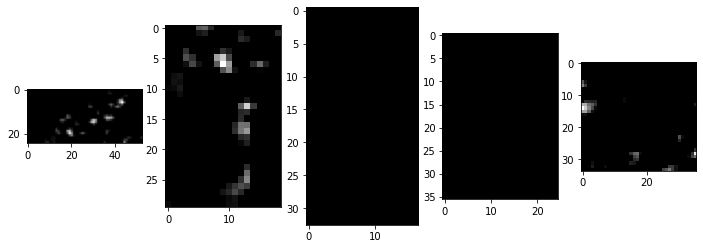

In [140]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    
    figNo +=1
plt.show()

In [141]:
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([128, 25088])


# Fast R-CNN

1) Classifier and Bounding box regressor

In [142]:
# 128 boxes + features (7x7x512) of ROI samples are sent to 
# Detection network to predict the objects bounding box and clas of the input image

roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(DEVICE)
cls_loc = nn.Linear(4096, 2 * 4).to(DEVICE) # 1 class, 1 background, 4 coordiinates
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(DEVICE) # 1 class, 1 background

In [143]:
# passing the output of roi pooling to RoI head

k = roi_head_classifier(k.to(DEVICE))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)

print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [144]:
# Calculate the loss of Fast RCNN based on the gt bboxes and features (h, w, d=512) 
# corresponding to these 128 ROIs

# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [145]:
gt_roi_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

2) Classification loss

In [146]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)

torch.Size([128, 4]) torch.Size([128])


3) Regression loss

In [147]:
# regression loss

n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

torch.Size([128, 2, 4])


In [148]:
roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

torch.Size([128, 4])


In [149]:
# for regression we use smooth l1 loss as defined in the Fast R-CNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

torch.Size([128, 4])


In [150]:
# take those bounding boxes which have positive labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(roi_loc_loss.sum())

torch.Size([0, 4]) torch.Size([0, 4])
tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)


4) Multi-task loss

In [151]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)

total_loss = rpn_loss + roi_loss
print(total_loss)

tensor([], size=(0, 4), dtype=torch.float64, grad_fn=<AddBackward0>)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!